In [1]:
import os
import numpy as np
import json
import glob
import random

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

In [141]:
# some helper functions used by all experiments

def all_files_with_prefix_and_suffix(location, prefix, suffix):
    """returns a list of all files in the 'location' starting with the given prefix"""
    if location[-1] != '/':
        location += '/'
    files = glob.glob(location + prefix + '*' + suffix)

    return files


def plot_sensitivity(param_list, item, param2='alpha', title=None, firstn=-1, last_from=-1, 
                     num_sa=None, logbase=-1, ylabel='RMSVE\n(TVR)', y_lims=None,
                     out_location=None, final=False, param_choose_only=None):

    data_all = {}
    X, Y = [], []
    for location, filename_prefix, param1 in param_list:
    
        files = all_files_with_prefix_and_suffix(location, filename_prefix, '*.npy')
        assert len(files) > 0, 'No files found with the prefix: ' + location + filename_prefix
        print('Filename\t%s\t%s\tValue\n' % (param1, param2))
        for file in files:
            data = np.load(file, allow_pickle=True).item()
            param1_value = data['params'][param1]
            if data['params'][param_choose_only[0]] != param_choose_only[1]:
                continue
            if data['params']['eta'] > 1:
                continue
            if param1_value not in data_all:
                data_all[param1_value] = {}
                X.append(param1_value)
            param2_value = data['params'][param2]
            if param2_value not in data_all[param1_value]:
                data_all[param1_value][param2_value] = {}
                Y.append(param2_value)
            assert not (firstn!=-1 and last_from!=-1), "Both firstn and lastn can't be chosen together"
            if firstn != -1:
                data_to_eval = data[item][:,:firstn]
            elif last_from != -1:
                data_to_eval = data[item][:,last_from:]
            else:
                data_to_eval = data[item]
            metric_per_run = np.mean(data_to_eval, axis=1)
            metric = np.mean(metric_per_run)
            metric_stderr = np.std(metric_per_run) / np.sqrt(metric_per_run.size)
            data_all[param1_value][param2_value] = (metric, metric_stderr)
            print('%s\t%s\t%s\t%.3f\t%.3f' % (file[-10:-3], param1_value, param2_value, metric, metric_stderr))

    try: 
        X = sorted(set(X))
    except:
        print('Cannot sort; keys are a mix of numbers and letters')
        X = data_all.keys()
    Y = sorted(set(Y))
    Z_mean = np.zeros((len(X), len(Y)))
    Z_stderr = np.zeros((len(X), len(Y)))
    Z_attrs = ['']*len(X)
    # print(Z_attrs)
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            try:
                Z_mean[i][j] = data_all[x][y][0]
                Z_stderr[i][j] = data_all[x][y][1]
            except:
                Z_mean[i][j] = np.nan
                Z_stderr[i][j] = np.nan
        print(i, x)
#         if x=='max_all_sa':
#             Z_attrs[i] = 'dashed'
    Z_mean = np.ma.masked_invalid(Z_mean)
    Z_stderr = np.ma.masked_invalid(Z_stderr)

    fig, ax = plt.subplots(1, 1)#, figsize=(5.5,4))

    # colors = ['darkturquoise', 'magenta']
    # if param_choose_only[0] in ['gamma', 'eta']:
    #     print('Changing value_init/reward_rate_init to reward_offset')
    #     X = list(map((lambda x: x * -1), X))
    for i, param_value in enumerate(X):
        ax.errorbar(Y, Z_mean[i], yerr=Z_stderr[i], label=str(param_value))#, linestyle=Z_attrs[i])#, color=colors[i])
    if final!=True:
        ax.legend()
        plt.xlabel(param2)
        plt.ylabel(ylabel, rotation=0, labelpad=40)
        ax.set_title(title)
    if y_lims != None:            # typically (0.21, 0.39) for TC, (2.05, 2.6) for AC, (0, 0.9) for Catcher
        plt.ylim(y_lims[0], y_lims[1])
    ax.grid(visible=True, axis='y', alpha=0.5, linestyle='--')
    if logbase != -1:
        ax.set_xscale("log", base=logbase)
    ax.set_xticks(Y)
    ax.set_xticklabels(Y)
    fig.tight_layout()
    if final==True:
        assert os.path.isfile(out_location + title + '.png') == False, "File already exists. Don't overwrite!"
        plt.savefig(out_location + title + '.png', dpi=1200, transparent=True)
    plt.show()


def plot_learning_curve(files, item='reward', window=1000, sample=1, firstn=-1,
                        title=None, h_line=None, ylims=None, plot_all_runs=False,
                        print_final_reward_rate=False, print_max_value_over_last_tenth=False,
                        out_location=None, final=False, file_title=None):

#     colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    colors = ['blue', 'orange', '#37f24a', '#2cbd3d', '#208c2b', '#f24235', '#bd332a', '#8f2822']
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    which_step_size = 'alpha_w'
    for i, (location, filename) in enumerate(files):
        data = np.load(location + filename, allow_pickle=True).item()
        rewards_train = data[item][:,:firstn]
#         if data['params']['robust_to_initialization']:
#             rewards_train -= data['params']['reward_offset']
        max_run_length = rewards_train.shape[1]
        if print_final_reward_rate:
            idx = int(data["avgrew"].shape[1] * 0.1)
#             print(f'Over {data["params"]["num_runs"]} runs: {np.mean(data["avgrew"][:,-10:])} +- {np.std(data["avgrew"][:,-10:])}')
            print(f'Learned reward rate (final): {np.mean(data["avgrew_final"]):.3f}')
            print(f'Learned reward rate over last 10%: {np.mean(data["avgrew"][:,-idx:]):.3f}')
        if print_max_value_over_last_tenth:
            print(f'Max value over the last 10% steps: {np.nanmean(data["max_value_per_step"])}\n')
        conv_arr = np.ones(window)
        reward_rate_all = []
        x_s = np.arange(window, max_run_length+1)[::sample] #* data['params']['eval_every_n_steps']
        # ToDo: vectorize this
        for run in range(rewards_train.shape[0]):
            reward_rate = np.convolve(rewards_train[run,:], conv_arr, mode='valid') / window
            reward_rate_all.append(reward_rate)
            if plot_all_runs:
                plt.plot(x_s, reward_rate, alpha=0.1, color=colors[i % len(colors)])
        reward_rate_all = np.array(reward_rate_all)
        mean = np.mean(reward_rate_all, axis=0)
        stderr = np.std(reward_rate_all, axis=0) / np.sqrt(reward_rate_all.shape[0])
        y_s = mean[::sample]
        stderr_s = stderr[::sample]
        agent_name = data['params']['agent_name']
        plt.plot(x_s, y_s, label=agent_name, color=colors[i % len(colors)])
        plt.fill_between(x_s, y_s + stderr_s, y_s - stderr_s, alpha=0.3, color=colors[i % len(colors)])

    if h_line!= None:
        plt.axhline(y=h_line, color='black', alpha=0.3, linestyle='--')
    plt.grid(visible=True, axis='y', alpha=0.5, linestyle='--')
    if ylims != None:
        plt.ylim(ylims[0], ylims[1])
    if not final:
        plt.legend()
        plt.title(title)
        plt.xlabel('Time steps')
        plt.ylabel('RMSVE\n(TVR)', rotation=0, labelpad=40)
    plt.tight_layout()
    if final:
        assert os.path.isfile(out_location + file_title + '.png') == False, "File already exists. Don't overwrite!"
        plt.savefig(out_location + file_title + '.png', dpi=1200, transparent=True)
    plt.show()
        
    
def plot_weights_prediction(filename, last_n_percent_weights=10,
                            print_per_run=False, title="", ylims=None, run_idx=None, plot_all_runs=False):
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'olive', 'cyan', 'gray']
    
    data = np.load(filename, allow_pickle=True).item()
    weights = data['weights']#[:,:20]
    num_runs, num_steps, num_states = weights.shape
    avg_r_all = data['avgrew']#[:,:20]
    x_s = np.arange(weights.shape[1]) * data['params']['eval_every_n_steps']

    idx = int(weights.shape[1] * last_n_percent_weights/100)
    print('Average weights (and r-bar) over last 10% steps:')
    print(np.mean(np.mean(weights[:,-idx:,:], axis=0), axis=0), np.mean(avg_r_all[:,-idx:]))
    if print_per_run:
        weights_avg = np.mean(weights[:,-idx:,:], axis=1)
        # print(weights_avg)
        avg_rew_avg = np.mean(avg_r_all[:,-idx:], axis=1)
        print(np.concatenate((weights_avg, avg_rew_avg[:, np.newaxis]), axis=1))

    fig, axes = plt.subplots(1, 1, figsize = (8,4))
    for s in range(num_states):
        if run_idx is not None:
            plt.plot(weights[run_idx,:,s], label=str(s))
        else:
            if plot_all_runs:
                for r in range(num_runs):
                    plt.plot(weights[r,:,s], color=colors[s%10], alpha=0.1)
            mean = np.mean(weights[:,:,s], axis=0)
            stderr = np.std(weights[:,:,s], axis=0) / np.sqrt(weights.shape[0])
            axes.plot(x_s, mean, label=str(s), color=colors[s%10])
            axes.fill_between(x_s, mean + stderr, mean - stderr, color=colors[s%10], alpha=0.3)
    if run_idx is not None:
        plt.plot(avg_r_all[run_idx], label=r'$\bar{R}$')
    else:
        if plot_all_runs:
            for r in range(num_runs):
                plt.plot(avg_r_all[r,:], color=colors[(s+1)%10], alpha=0.1)
        avg_r_mean = np.mean(avg_r_all, axis=0)
        avg_r_stderr = np.std(avg_r_all, axis=0) / np.sqrt(avg_r_all.shape[0])
        axes.plot(x_s, avg_r_mean, color=colors[(s+1)%10], label=r'$\bar{R}$')
        axes.fill_between(x_s, avg_r_mean + avg_r_stderr, avg_r_mean - avg_r_stderr, color=colors[s%10], alpha=0.3)

    axes.legend()
    # plt.yscale('log', basey=10)
    axes.grid(visible=True, axis='y', alpha=0.5, linestyle='--')
    if ylims is not None:
        plt.ylim(ylims[0], ylims[1])
    plt.title(title)
    plt.tight_layout()
#     assert os.path.isfile(title + '_weights.png') == False, "File already exists. Don't overwrite!"
#     plt.savefig(title + '_weights.png')
    plt.show()

def plot_learned_r_bar(filename, title="", ylims=None):
    data = np.load(filename, allow_pickle=True).item()
    num_runs = data['params']['num_runs']
    for i in range(num_runs):
        plt.plot(data['avgrew'][i,:], color='blue', alpha=0.3)
    plt.show()
    
def print_config(filename):

    data = np.load(filename, allow_pickle=True).item()
    params = data['params']
    print(params)

## RW7

In [3]:
def get_values_RW7(gamma, r_left, r_right):
    if gamma < 1:
        A = np.array([[1, -0.5*gamma, 0, -0.5*gamma, 0, 0, 0],
                      [-0.5*gamma, 1, -0.5*gamma, 0, 0, 0, 0],
                      [0, -0.5*gamma, 1, -0.5*gamma, 0, 0, 0],
                      [0, 0, -0.5*gamma, 1, -0.5*gamma, 0, 0],
                      [0, 0, 0, -0.5*gamma, 1, -0.5*gamma, 0],
                      [0, 0, 0, 0, -0.5*gamma, 1, -0.5*gamma],
                      [0, 0, 0, -0.5*gamma, 0, -0.5*gamma, 1]])
        b = np.array([0.5*r_left, 0, 0, 0, 0, 0, 0.5*r_right])
    else:
        r_pi = 1/32 * (r_left + r_right)
        A = np.array([[1, -0.5, 0, -0.5, 0, 0, 0],
                      [-0.5, 1, -0.5, 0, 0, 0, 0],
                      [0, -0.5, 1, -0.5, 0, 0, 0],
                      [0, 0, -0.5, 1, -0.5, 0, 0],
                      [0, 0, 0, -0.5, 1, -0.5, 0],
                      [0, 0, 0, -0.5, 0, 1, -0.5],
                      [1/16, 2/16, 3/16, 4/16, 3/16, 2/16, 1/16]])
        b = np.array([0.5*r_left - r_pi, -r_pi, -r_pi, -r_pi, -r_pi, -r_pi, 0])
    
    return np.matmul(np.linalg.inv(A), b)

k=3
d_pi = [1 / (k + 1) * i / (k + 1) for i in range(1, k + 1)] + [1 / (k + 1)] + [1 / (
                            k + 1) * i / (k + 1) for i in range(1, k + 1)][::-1]

In [4]:
v_pi_9 = get_values_RW7(0.9, 1, 7)
print(v_pi_9)
print(v_pi_9 - 2.5)
print(np.dot(v_pi_9 - 2.5, d_pi))

[2.121 1.684 1.621 1.918 2.642 3.953 6.142]
[-0.379 -0.816 -0.879 -0.582  0.142  1.453  3.642]
1.27675647831893e-15


In [56]:
v_pi_99 = get_values_RW7(0.99, 1, 7)
print(v_pi_99)
print(v_pi_99 - 25)
print(np.dot(v_pi_99 - 25, d_pi))

[24.405 23.913 23.905 24.379 25.346 26.825 28.846]
[-0.595 -1.087 -1.095 -0.621  0.346  1.825  3.846]
-1.9984014443252818e-14


## b=[0.5, 0.5]

## gamma=0.9

Filename	avg_reward_init	alpha	Value

b0.5_3.	0	0.08	0.329	0.003
b0.5_2.	0	0.04	0.319	0.003
b0.5_0.	0	0.01	0.723	0.007
b0.5_1.	0	0.02	0.420	0.005
b0.5_4.	0	0.16	0.420	0.003
0.5_14.	0.25	0.16	0.397	0.003
0.5_11.	0.25	0.02	0.177	0.003
0.5_10.	0.25	0.01	0.200	0.004
0.5_12.	0.25	0.04	0.206	0.002
0.5_13.	0.25	0.08	0.278	0.003
0 0
1 0.25


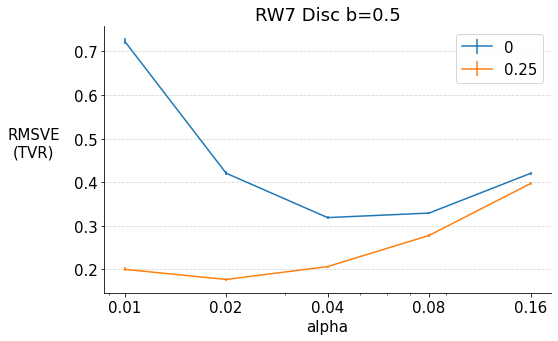

In [8]:
param_list = [('./results/centering/', 'RW7_DiscTD_b0.5', 'avg_reward_init'),]

plot_sensitivity(param_list, 'rmsve', ylabel='RMSVE\n(TVR)', param_choose_only=("gamma", 0.9),
                 logbase=10,
#                  y_lims=(0.5, 3), #firstn=400,
                 title=r'RW7 Disc b=0.5 $\gamma=0.9$', final=False)

Learned reward rate (final): 0.000
Learned reward rate over last 10%: 0.000
Learned reward rate (final): 0.250
Learned reward rate over last 10%: 0.250


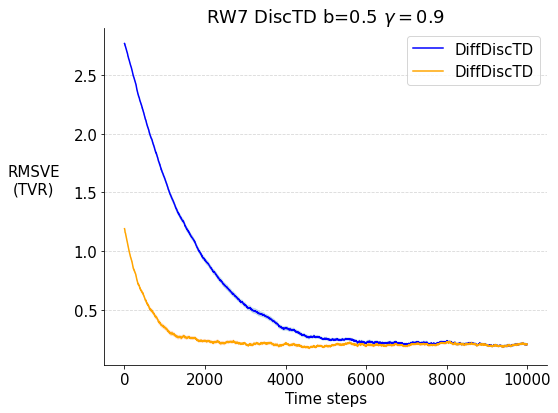

In [14]:
filenames = [
    ('results/centering/', 'RW7_DiscTD_b0.5_2.npy'),  # gamma=0.9, alpha=0.04, r_bar=0.00, decay=0.99999
    ('results/centering/', 'RW7_DiscTD_b0.5_11.npy'),  # gamma=0.9, alpha=0.02, r_bar=0.25, decay=0.99999
    ('results/centering/', 'RW7_DiscTD_b0.5_12.npy'),  # gamma=0.9, alpha=0.04, r_bar=0.25, decay=0.99999
]

plot_learning_curve(filenames, item='rmsve', window=1,
                    title=r'RW7 DiscTD b=0.5 $\gamma=0.9$', final=False, #plot_all_runs=True,
                    print_final_reward_rate=True, #ylims=(0, 4),
                    firstn=10000
                   )

Learned reward rate (final): 0.000
Learned reward rate over last 10%: 0.000
Learned reward rate (final): 0.250
Learned reward rate over last 10%: 0.250
Learned reward rate (final): 0.250
Learned reward rate over last 10%: 0.248
Learned reward rate (final): 0.254
Learned reward rate over last 10%: 0.248


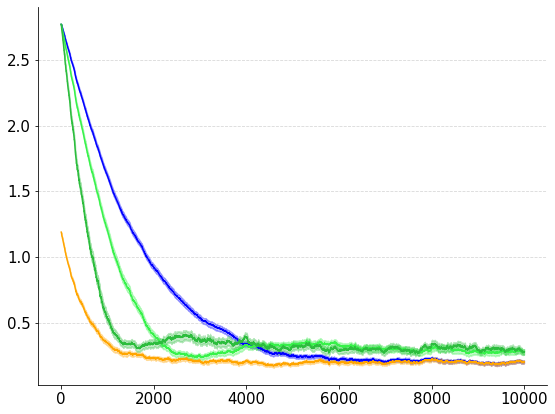

In [130]:
filenames = [
    ('results/centering/', 'RW7_DiscTD_b0.5_2.npy'),  # gamma=0.9, alpha=0.04, r_bar=0.00, decay=0.99999
    ('results/centering/', 'RW7_DiscTD_b0.5_12.npy'),  # gamma=0.9, alpha=0.04, r_bar=0.25, decay=0.99999
#     ('results/centering/', 'RW7_CDiscTD_b0.5_gamma0.9_simple_0.npy'),  # gamma=0.9, alpha=0.04, eta=1/640, decay=0.99999
    ('results/centering/', 'RW7_CDiscTD_b0.5_gamma0.9_simple_1.npy'),  # gamma=0.9, alpha=0.04, eta=1/160, decay=0.99999
    ('results/centering/', 'RW7_CDiscTD_b0.5_gamma0.9_simple_2.npy'),  # gamma=0.9, alpha=0.04, eta=1/40, decay=0.99999
#     ('results/centering/', 'RW7_CDiscTD_b0.5_gamma0.9_simple_3.npy'),  # gamma=0.9, alpha=0.04, eta=1/10, decay=0.99999
]

plot_learning_curve(filenames, item='rmsve', window=1,
                    title=r'[*] RW7 b=0.5 (none and simple) $\alpha=0.04, \gamma=0.9$', final=True, #plot_all_runs=True,
                    print_final_reward_rate=True, #ylims=(0, 4),
                    out_location='results/centering/plots/', file_title='RW7_on_simple_gamma0.9_alpha0.04',
                    firstn=10000
                   )